In [21]:
import csv
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyreadr import pyreadr
from matplotlib import pyplot

In [34]:
plt.rcParams['figure.figsize'] = [15, 5]  # Bigger images
plt.rcParams['font.size']= 14

In [ ]:
result = pyreadr.read_r('osfstorage-archive/RDS/eda.rds') # also works for RData
# result is a dictionary where keys are the name of objects and the values python
# objects. In the case of Rds there is only one object with None as key
df = result[None] # extract the pandas data frame
df2=df[df['subject']=='02']
df2

In [ ]:
df['subject'].unique()

In [ ]:
df['CR'].max()

In [ ]:
df['CR'].min()

CR potrebbe essere la skin response from 0.03 to 9.84

ln_cr è la CR scaled with a log to reduce the skew of the amplitude distribution

threat -> da 1 a 6
probably
1 cs-
2 gs1
3 gs2
4 gs3
5 gs4
6 cs+

try to use this cr colomn in this rds, what is the sampling rate? un dato ogni 8 secondi


    sampling rate = num lines/durata esperimento

In [ ]:
num_lines= len(df['CR'])
print(num_lines)

In [ ]:
start_exp=df['time.start'].min()
print(start_exp)

In [ ]:
end_exp=df['time.end'].max()
print(end_exp)

In [ ]:
sampl_r=(end_exp-start_exp)/num_lines
sampl_r

se ipotizzo sampling rate di 500hz e lo moltiplico per la lunghezza del sample dovrei ottenere il tempo totale  ma 10 sec è un tempo ridicolo quindi sampling rate <<500hz

In [ ]:
0.002*num_lines

In [ ]:
rows['CDA.Tonic'].plot()

# analisi file eda uno per uno

## riassumendo

eda 4 file dati

a) file 01.txt solo CH1
1 file per ogni partecipante con sampling rate noto (500HZ)
più di 1.4 M rows
quindi il segnale totale dura circa 284992 secondi
segnale che contiene sum di phasic e tonic
il vantaggio di questo tipo di file è che siamo già sincronizzati con heart (a meno di latenze)

colonne
CH1 --> eda
CH2 --> heartrate
CH28 --> trigger

b)01_era.txt
1 file per ogni partecipante senza sampling rate
188 righe
durata segnale boh
contiene phasic e tonic già divisa
forse dati costruiti using Continuous Decomposition Analysis dai file 01.txt avrebbe senso con una certa media (che in teoria serve a dividere thonic da phasic)

'Event.Nr' --> int da 0 a 188
'CDA.nSCR' --> int da 0 a 4
'CDA.Latency' --> flot from 0.5 to 3.0
'CDA.AmpSum' --> float from 0 to 1.3
'CDA.SCR' --> float from 0 to 0.1 forse valori di skin conductance response (phasic values)
'CDA.ISCR' --> flot from 0 to 5.5 forse valori di integrated skin conductance response ( uguale a 'CDA.SCR'*45 )
'CDA.PhasicMax' --> float from 0 to 6.1 (molto simile a ISCR)
'CDA.Tonic' --> float from 9.9 to 10.9 forse valori della parte tonic
'TTP.nSCR' --> int from 0 to 2 pare nessuna relazione con CDA.nSCR
'TTP.Latency' --> float from 0.5 to 2.8 non capisco se correlata o meno a CDA latency
'TTP.AmpSum' --> float from 0 to 1.3 sembra correlato con CDA.ampsum
'Global.Mean' --> float from 9.9 to 11.7 mean ma di cosa?
'Global.MaxDeflection' --> float from 0 to 1 deflection de che? dalla media?
'Event.NID' --> solo 1 o 2 direi useless
'Event.Name' --> solo "1" o "2" direi useless



c)eda.ucr.rds
1 file per tutti
contiene 1 solo value per ogni paziente 'ucr'

'subject' --> boolean
'ucr' --> unconditioned? conductance response
'valid' --> float from 0 to 1
'include' --> boolean sembra correlato con valid (sembra una sua approssimazione)
'ln_ucr' -->  unconditioned? conductance response con una trasformazione logaritmica

come se ucr fosse una baseline per ogni paziente?


d)eda.rds
1 file unico con 1 dato ogni trial
info su trial, threat, paziente
'trial' --> informazione sul trial (da 1 a 160)
'condition' --> data dall'unione di pair e threat (pair+threat)
'threat' --> da 1 a 6 (1:cs- 2:gs1 3:gs2 4:gs3 5:gs4 6:cs+)
'pair' --> da 1 a 4
'shock' --> boolean
'shockPrior' --> boolean
'time.start' --> time.end-8
'time.end' -->
'sample.start' --> differisce di un fattore moltiplicato k circa 500 da time.start
'sample.end' --> differisce di un fattore moltiplicato k circa 500 da time.end
'CR' --> conductance response
'subject' --> paziente
'diagnostic' --> region of interest
'pairs' --> 1 o 2 legato a pair?
'ln_cr' --> conductance response con una trasformazione logaritmica


## a) file 01.txt

decompose into tonic e phasic

## b)01_era.txt

In [ ]:
#era.txt
with open('osfstorage-archive/physio/ledalab/01_era.txt') as f:
    lines = f.readlines()
lines = list(lines)
lines = [line.replace('\n', "") for line in lines]
lines[:10]
columns = lines[0].split('\t')
rows = [row.split("\t") for row in lines[1:]]

with open('csv_tmp', 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)

    write.writerow(columns)
    write.writerows(rows)

# creating csv
df_era = pd.read_csv("csv_tmp")
df_era

In [ ]:
diff = np.subtract(df_era['CDA.Latency'].astype(float),df_era['TTP.Latency'].astype(float))
diff

In [ ]:
pyplot.plot(df_era['CDA.AmpSum'])
pyplot.plot(df_era['TTP.AmpSum'])

In [ ]:
pyplot.plot(df_era['CDA.ISCR'])
pyplot.plot(df_era['CDA.SCR']*45)

In [ ]:
pyplot.plot(df_era['CDA.ISCR'])
pyplot.plot(df_era['CDA.PhasicMax'])

In [ ]:
#analyze diff between latency

cda_lat=np.array(df_era['CDA.Latency']).astype(float)
ttp_lat=np.array(df_era['TTP.Latency']).astype(float)
res = np.subtract(cda_lat,ttp_lat)
res = res[~np.isnan(res)]

pyplot.plot(res)

## c)eda.ucr.rds

In [ ]:
result = pyreadr.read_r('osfstorage-archive/RDS/eda.ucr.rds')
df = result[None]
df

In [ ]:
pyplot.plot(np.log10(df['ucr'])+1)
pyplot.plot(df['ln_ucr'])

In [ ]:
pyplot.plot(df['valid'])
pyplot.plot(df['include'])

## d)eda.rds

In [ ]:
result = pyreadr.read_r('osfstorage-archive/RDS/eda.rds')
df = result[None]
df

In [ ]:
(df['sample.end']-df['sample.start']).unique()

In [ ]:
(df['time.end']-df['time.start']).unique()

In [ ]:
df_=df
df_['pair'] = df_['pair'].apply(np.int64).astype(str)
df_['threat'] = df_['threat'].apply(np.int64).astype(str)
df_['pair_threat'] = df_['pair']+df_['threat']
df_['pair_threat'] = df_['pair_threat'].astype(float)
np.subtract(df_['condition'],df_['pair_threat']).unique()

la colonna condition è data esattamente dall'unione di pair e threat

In [ ]:
shock_=[1 if x=='True' else 0 for x in df['shock']]
shockprior_=[1 if x=='True' else 0 for x in df['shockPrior']]
x_ = (np.subtract(shock_,shockprior_))
y_ = [x for x in range(0,len(x))]
pyplot.plot(y_,x_,linewidth=0.4)
pyplot.xlim(0,200)

In [ ]:
print('count -1: '+str(list(x_).count(-1)))
print('count 1: '+str(list(x_).count(1)))
print('count 0: '+str(list(x_).count(0)))

Essendoci la maggioranza di valori a 0 la maggior parte di valori di shock pror e shock coincidono

In [ ]:
pyplot.plot(df['time.start']*400)
pyplot.plot(df['sample.start'])

In [ ]:
pyplot.plot(df['time.end']*400)
pyplot.plot(df['sample.end'])

In [ ]:
print(df['condition'].sort_values().unique())

# paragone 01.txt e 01_era.txt

read 01_era.txt

In [ ]:
with open('osfstorage-archive/physio/ledalab/01_era.txt') as f:
    lines = f.readlines()
lines = list(lines)
lines = [line.replace('\n', "") for line in lines]
lines[:10]
columns = lines[0].split('\t')
rows = [row.split("\t") for row in lines[1:]]

with open('csv_tmp', 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)

    write.writerow(columns)
    write.writerows(rows)

# creating csv
rows_era = pd.read_csv("csv_tmp")
rows_era

read 01.txt

In [ ]:
for i in range(1,56):
    path = r"./osfstorage-archive/physio/"
    ext=".txt"
    new_name="tmp_eda"

    if i<10:
        path = path+"0"
        new_name =new_name+"0"

    filename=path+str(i)+ext
    new_name=new_name+str(i)+".csv"

    try:
        with open(filename, 'r') as fp:
            lines = (fp.readlines())
    except FileNotFoundError as e:
        continue

    if("EDA" not in lines[3]):
        print("error not eda file")
        break

    lines_eda_good = lines[11:]     # remove parte descrittiva iniziale nel file, tenendo solo columns e dati

    # formatting in csv
    lines_eda_good = [line.replace("\t", " ") for line in lines_eda_good]
    lines_eda_good = [line.replace("\n", "") for line in lines_eda_good]

    fields = ["CH1","CH2","CH28"]
    rows = [ row.split(" ") for row in lines_eda_good ]
    rows = [row[:3] for row in rows]
    with open(new_name, 'w') as f:

        # using csv.writer method from CSV package
        write = csv.writer(f)

        write.writerow(fields)
        write.writerows(rows)


# HERE CREATION INTERMEDIATE CSV

In [4]:
data_real = pd.read_csv("tmp_eda/tmp_eda01.csv")
len(data_real)

1421036

In [5]:
eda_real = data_real['CH1']
eda_real

0          7.968140
1          7.968140
2          7.969670
3          7.971190
4          7.969670
             ...   
1421031   -0.004578
1421032   -0.001526
1421033   -0.003052
1421034   -0.003052
1421035   -0.003052
Name: CH1, Length: 1421036, dtype: float64

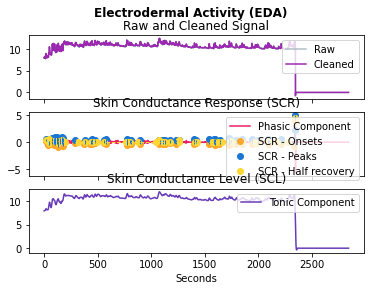

In [6]:
signals_txt, info_txt = nk.eda_process(eda_real, sampling_rate=500,method="neurokit")
# Visualise the processing
nk.eda_plot(signals_txt, sampling_rate=500)

plt.show()

In [10]:
print(signals_txt.keys())

Index(['EDA_Raw', 'EDA_Clean', 'EDA_Tonic', 'EDA_Phasic', 'SCR_Onsets',
       'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime',
       'SCR_Recovery', 'SCR_RecoveryTime'],
      dtype='object')


In [ ]:
signals_txt
signals_txt_ = signals_txt.reset_index(drop=False)
signals_txt_ = signals_txt[['EDA_Phasic','EDA_Tonic']]
signals_txt_[:8650].mean()

In [ ]:
list_txt_ph = signals_txt_['EDA_Phasic']
list_txt_to = signals_txt_['EDA_Tonic']

In [ ]:
rows_era_ = rows_era.reset_index(drop=False)
rows_era_ = rows_era[['CDA.SCR','CDA.Tonic']]
rows_era_

In [ ]:
list_era_ph = rows_era_['CDA.SCR']
list_era_to = rows_era_['CDA.Tonic']

In [ ]:
min_ = min(len(list_txt_ph),len(list_era_ph))
min_

In [ ]:
range_=len(list_txt_ph)-len(list_era_ph)
range_

vediamo se c'è qualche tipo di correlazione tra queste due cose

In [ ]:
max_rho = float(-1)
min_rho = float(1)
index_max = 0
index_min = 0
for i in range(range_):
    x_simple = np.array(list_era_ph)[:min_]
    y_simple = np.array(list_txt_ph)[i:min_+i]
    my_rho = float(np.corrcoef(x_simple, y_simple)[0][1])

    if my_rho > max_rho:
        max_rho = my_rho
        index_max = i

    if my_rho < min_rho:
        min_rho = my_rho
        index_min = i
print("max ",max_rho,index_max)
print("min ",min_rho,index_min)

non sembra esserci correlazione apparente, ma magari i secondi sono un qualche tipo di media? come lo verifico?

In [ ]:
max_rho = float(-1)
min_rho = float(1)
index_max = 0
index_min = 0
for i in range(range_):
    x_simple = np.array(list_era_to)[:min_]
    y_simple = np.array(list_txt_to)[i:min_+i]
    my_rho = float(np.corrcoef(x_simple, y_simple)[0][1])

    if my_rho > max_rho:
        max_rho = my_rho
        index_max = i

    if my_rho < min_rho:
        min_rho = my_rho
        index_min = i
print("max ",max_rho,index_max)
print("min ",min_rho,index_min)

# sync pupil e file .txt ch1

In [1]:
import csv
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyreadr import pyreadr

In [55]:
plt.rcParams['figure.figsize'] = [15, 5]  # Bigger images
plt.rcParams['font.size']= 16

remove patients non valid for eda

In [3]:
notvalid = [x for x in range(34,41)]
notvalid.append(9)

valid_patients_eda = [ele for ele in range(1,56) if ele not in notvalid]

remove patients non valid for pupil

In [4]:
notvalid = [x for x in range(34,41)]
notvalid.extend([9,20,25,42])

valid_patients_pupil = [ele for ele in range(1,56) if ele not in notvalid]

select patients with either pupil and eda data

In [5]:
valid_pupil_eda = list(set(valid_patients_eda).intersection(set(valid_patients_pupil)))

## test with first person

extract pupil data of the first patient

In [6]:
# person 1
pupil1 = pd.read_csv('../osfstorage-archive/eye/pupil/Look001_pupil.csv', sep=';')
for i in (pupil1.columns):
    if i != 'trial':
        for j in pupil1.index:
            pupil1.loc[j, i] = pupil1.loc[j, i].replace(',', '.')
cols = pupil1.columns.drop('trial')

pupil1[cols] = pupil1[cols].apply(pd.to_numeric, errors='coerce')

In [119]:
pupil1

pandas.core.frame.DataFrame

In [ ]:
# convert all datas into one list
pat1_pupil = []
for i in range(160):
    colonne = pupil1.columns.drop(['trial'])
    for colonna in colonne:
        pat1_pupil.append(pupil1.loc[i][colonna])
pat1_pupil

sampling rate of pupil data --> 100hz

Plot pupil

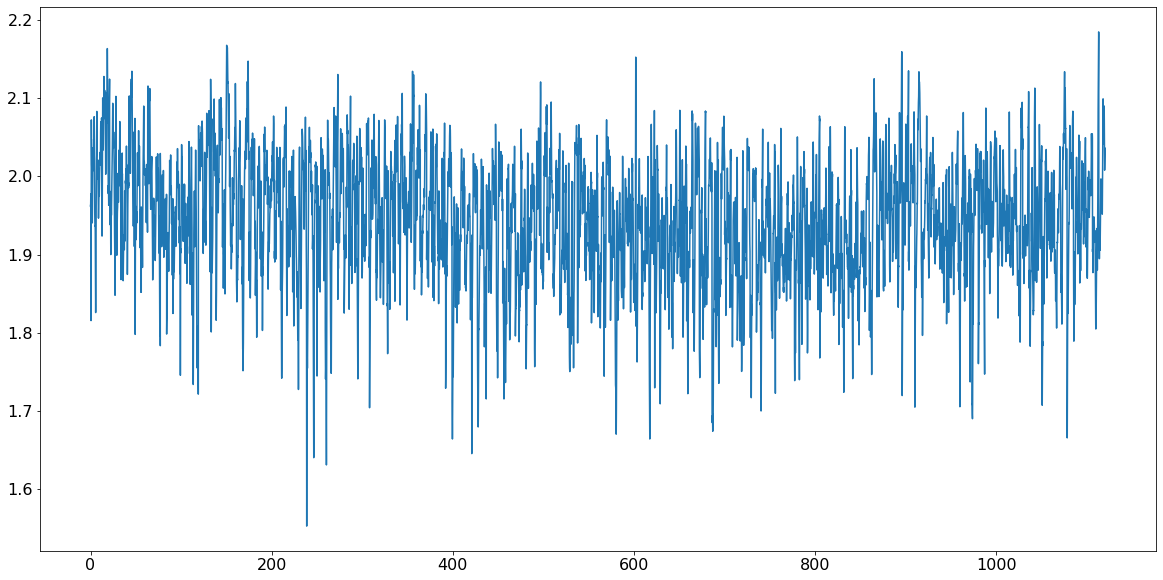

In [50]:
X = np.arange(0, 7*160, 0.01)
Y = list(pat1_pupil)
plt.plot(X, Y)
plt.show()

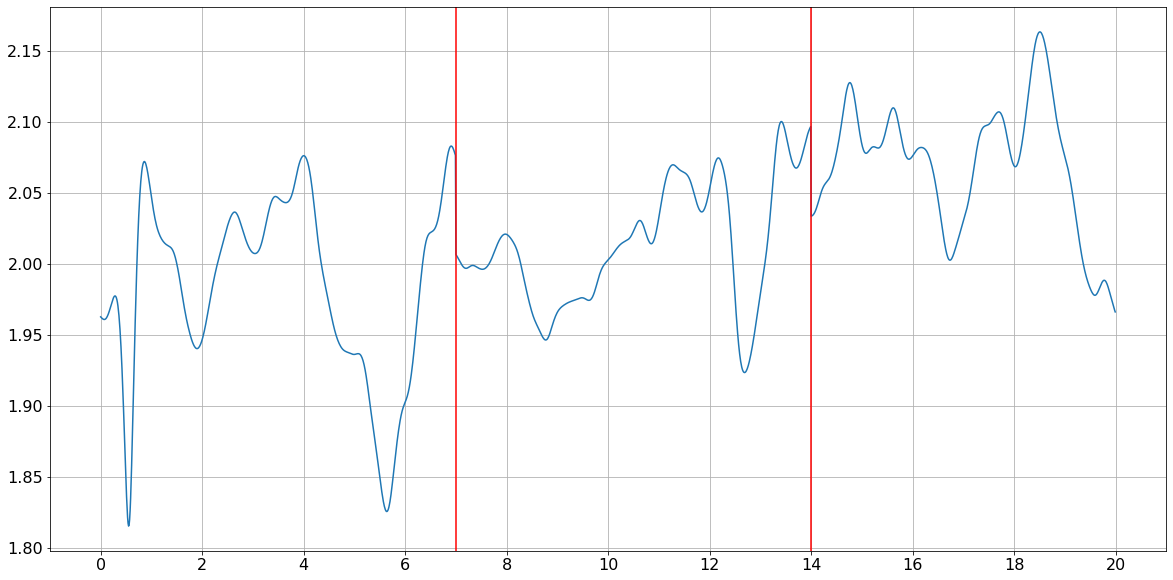

In [51]:
# first 20 seconds of the pupil signal
X_20 = X[:20*100]
Y_20 = Y[:20*100]
plt.plot(X_20, Y_20)
plt.axvline(7, color='red') # trial separation
plt.axvline(14, color='red') # trial separation
plt.xticks(np.arange(0,21,2))
plt.grid()
plt.show()

extract eda data of patient 1

In [11]:
pat1_eda = pd.read_csv("../tmp_eda01.csv")['CH1']
pat1_eda.to_numpy()

array([ 7.96814e+00,  7.96814e+00,  7.96967e+00, ..., -3.05201e-03,
       -3.05201e-03, -3.05201e-03])

eda ha sampling rate di 500hz, pupil di 100hz.

In [12]:
print('len eda data '+str(len(pat1_eda)))
print('len pupil data '+str(len(pat1_pupil)))

len eda data 1421036
len pupil data 112000


In [13]:
(1421036/160)*0.002

17.76295

downsample eda data to 500hz to 100hz. I take only one sample every 5

In [14]:
pat1_eda_new = []

for x in range(len(pat1_eda)):
    if x%5==0:
        pat1_eda_new.append(pat1_eda[x])

eda con 100hz

In [15]:
len(pat1_eda_new)

284208

In [16]:
len(pat1_pupil)

112000

### divide eda into tonic e phasic

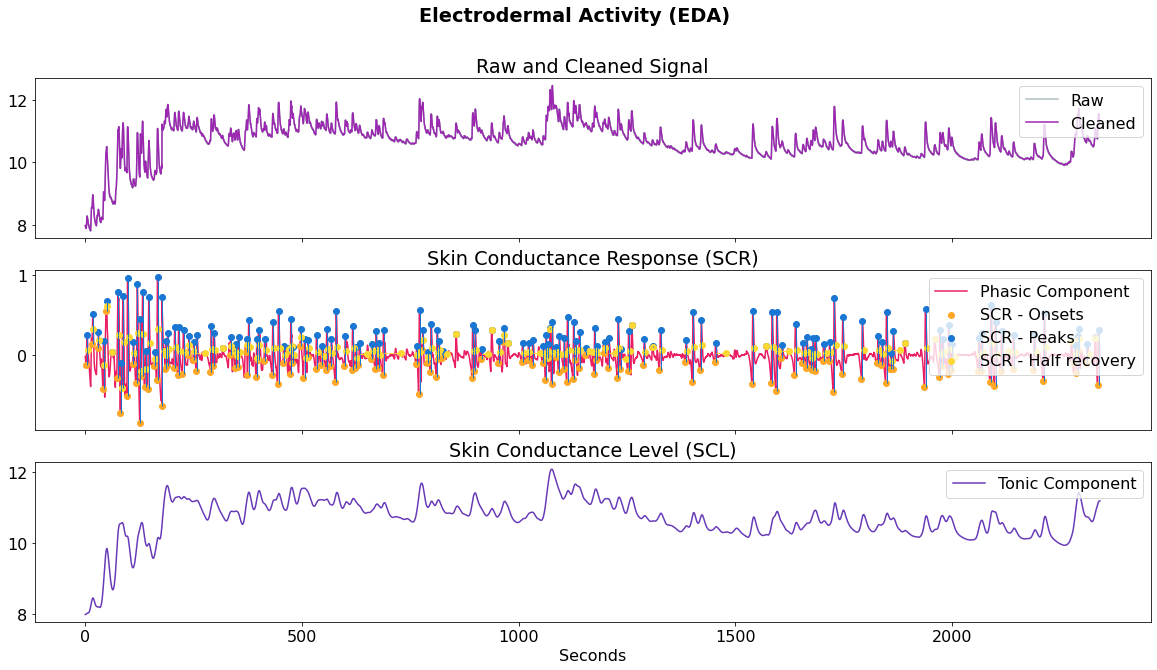

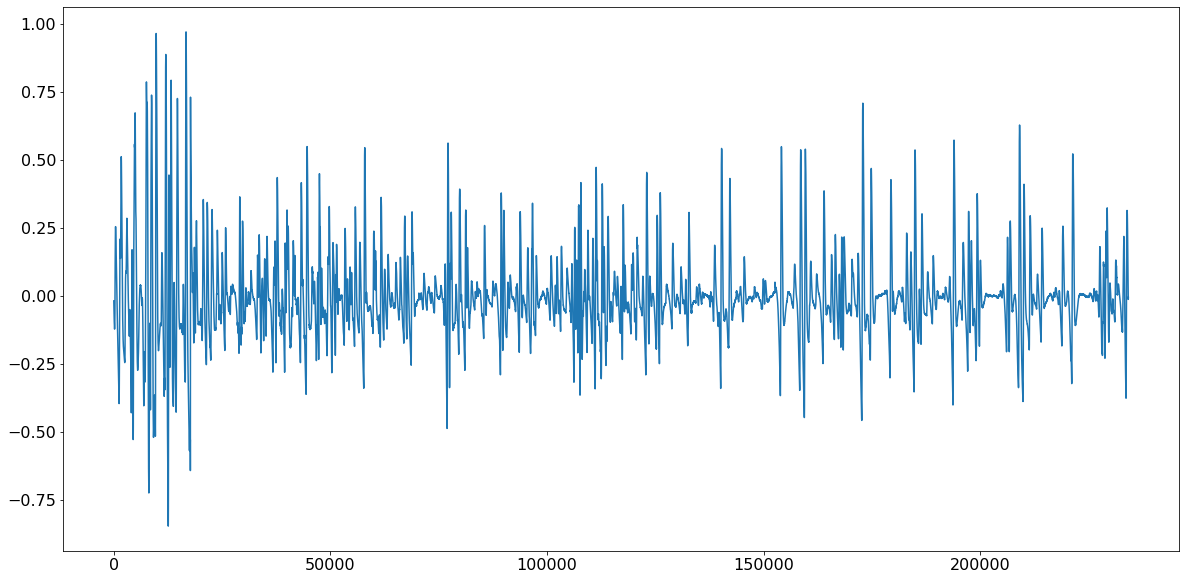

In [52]:
signals, info = nk.eda_process(pat1_eda_new, sampling_rate=100)
nk.eda_plot(signals, sampling_rate=100)
pat1_eda_phasic = signals['EDA_Phasic']
plt.show()
plt.plot(pat1_eda_phasic)

from this plot it seems that values after max aren't good so i decided to cut before this the signal

In [18]:
cut_index = pat1_eda_phasic[pat1_eda_phasic > 1].index.min()
cut_index

234130

In [19]:
pat1_eda_new = pat1_eda_new[:cut_index]

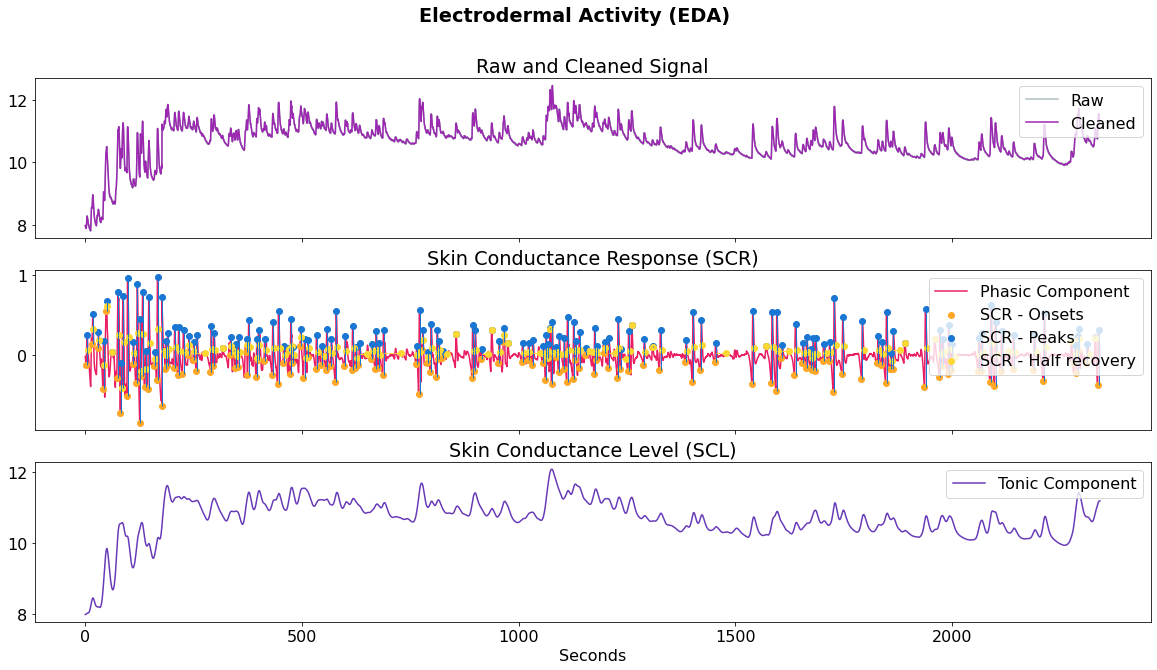

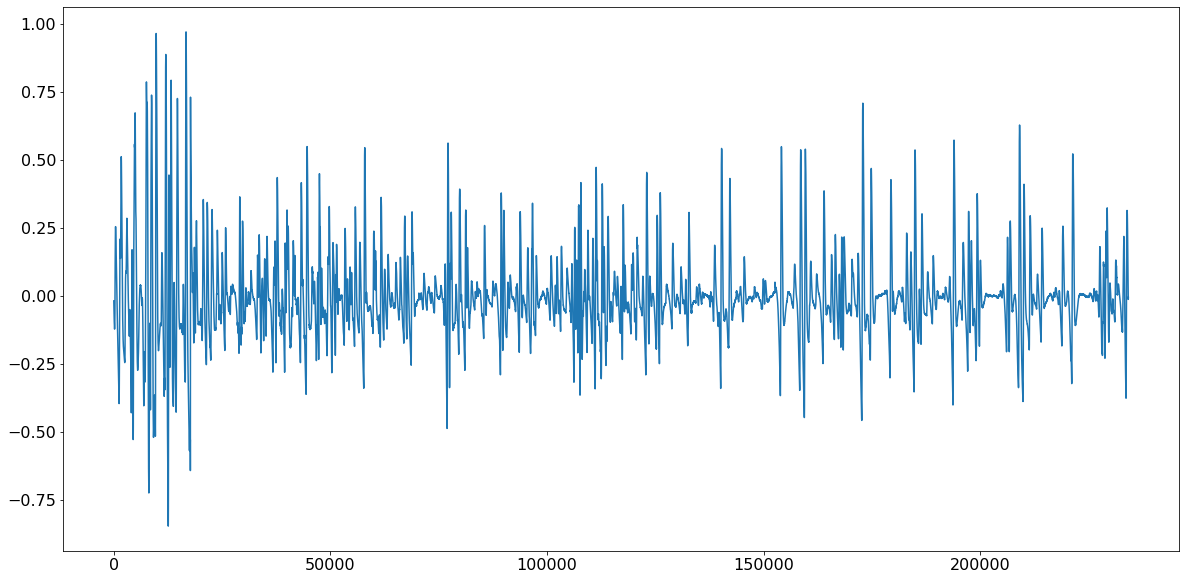

In [53]:
signals, info = nk.eda_process(pat1_eda_new, sampling_rate=100)
nk.eda_plot(signals, sampling_rate=100)
pat1_eda_phasic = signals['EDA_Phasic']
plt.show()
plt.plot(pat1_eda_phasic)
plt.show()

    if i cut eda signal i have to cut also pupil signal

In [124]:
signals['SCR_Peaks']

0         0
1         0
2         0
3         0
4         0
         ..
234125    0
234126    0
234127    0
234128    0
234129    0
Name: SCR_Peaks, Length: 234130, dtype: int64

In [129]:
signals[signals['SCR_Peaks']==1]['EDA_Phasic']

406       0.255622
1719      0.513169
3017      0.286372
4208      0.170545
4919      0.674347
            ...   
228989    0.239548
229249    0.324641
231241    0.132725
233098    0.219587
233834    0.315162
Name: EDA_Phasic, Length: 152, dtype: float64

TODO in realtà forse non è detto

In [21]:
if len(pat1_pupil)>cut_index:
    pat1_pupil = pat1_pupil[:cut_index]
    print("pupil cutted")

In [22]:
len(pat1_pupil)

112000

In [23]:
# total length in seconds of the signal
len_sec = len(pat1_eda_new)*0.01
len_sec

2341.3

In [24]:
NUM_TRIALS=160

In [25]:
len_sec/NUM_TRIALS

14.633125000000001

14.6 seconds every trial i think it's too much but i cut for example only first 100 seconds

latency of eda signal 5000 msec so i decided to shift to 5 sec the first 50 sec

In [87]:
LATENCY_EDA_SECS=5
LATENCY_PUPIL_SECS=1
LEN_SECS = 100

In [88]:
pat1_eda_lat = pat1_eda_new[(LATENCY_EDA_SECS*100):]
pat1_eda_cut = pat1_eda_lat[:(100*LATENCY_EDA_SECS)+(100*LEN_SECS)]

latency of pupil 1000 msec so i decided to shift 1 sec the first 50 secs

In [97]:
x_pupil_lat = X[(LATENCY_PUPIL_SECS*100):]
x_pupil_cut = x_pupil_lat[:(LEN_SECS*100)+(LATENCY_PUPIL_SECS*100)]

In [98]:
# trasform pupil data from secs to mseconds
x_pupil_cut = [x*100 for x in x_pupil_cut]

y_pupil_lat = Y[LATENCY_PUPIL_SECS*100:]

shift y to compare signal with eda

In [99]:
Y_SHIFT_ADD=-2
Y_SHIFT_MULT=5

In [100]:
y_pupil_lat_shifted = [(y+Y_SHIFT_ADD)*Y_SHIFT_MULT for y in y_pupil_lat]

In [101]:
y_pupil_cut = y_pupil_lat_shifted[:(LEN_SECS*100)+(LATENCY_PUPIL_SECS*100)]

### plot near first 100 secs eda and first 100 secs pupil

In [116]:
signals_cut, info_cut = nk.eda_process(pat1_eda_cut, sampling_rate=100)
pat1_eda_phasic_cut = signals_cut['EDA_Phasic']

10500


In [103]:
x_peaks = [i for i, value in enumerate(signals_cut['SCR_Peaks']) if value == 1]
print(x_peaks)
x_onsets = [i for i, value in enumerate(signals_cut['SCR_Onsets']) if value == 1]
print(x_onsets)
x_recovery = [i for i, value in enumerate(signals_cut['SCR_Recovery']) if value == 1]
print(x_recovery)

[1219, 2517, 3708, 4419, 5681, 7032, 7796, 8215, 8911, 9268]
[1036, 2334, 3543, 4303, 5646, 6745, 7590, 7954, 8786, 9094]
[1338, 2650, 3835, 4463, 5692, 7356, 7946, 8420, 9004, 9532]


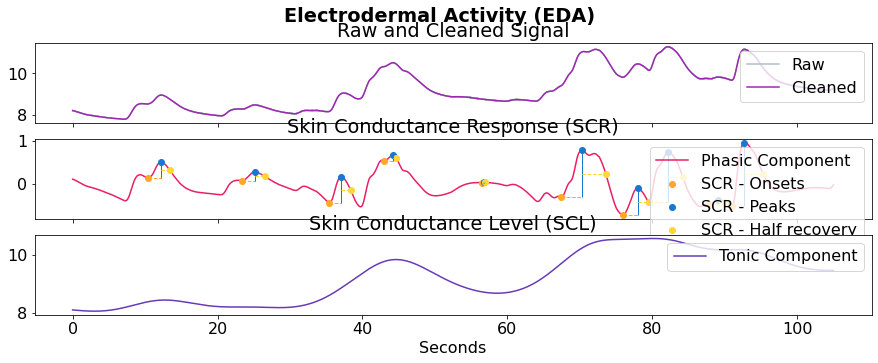

In [104]:
#plot total graph eda
nk.eda_plot(signals_cut, sampling_rate=100)
plt.show()

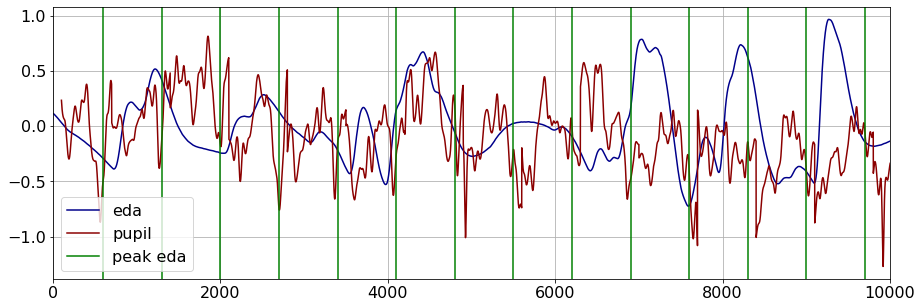

In [131]:
#eda plot
plt.plot(pat1_eda_phasic_cut,color='darkblue')

# pupil plot
plt.plot(x_pupil_cut, y_pupil_cut, color='darkred')

'''
#code to plot onsets points on eda
for x in x_onsets:
   plt.axvline(x/100,color='orange')

#code to plot recovery points on eda
for x in x_recovery:
   plt.axvline(x/100,color='red')
'''
#code to plot trial division
for x in range(600,10000,700):
    plt.axvline(x, color='green')
'''
for peak in x_peaks:
   plt.axvline(peak,color='orange')
'''
plt.grid()
plt.xlim(0,LEN_SECS*100)
plt.legend(['eda','pupil','peak eda'])
plt.show()

In [111]:
print(len(x_pupil_lat))
print(len(pat1_eda_lat))
print(len(y_pupil_lat_shifted))
min_ = min(len(pat1_eda_lat), len(y_pupil_lat_shifted))
min_

111900
233630
111900


111900

In [118]:
d = {'eda_phasic':pat1_eda_lat[:min_],'pupil_dilatation':y_pupil_lat_shifted[:min_],'subject':[1 for x in range(0,min_)]}
df_sync_pat1 = pd.DataFrame(d)
df_sync_pat1

,eda_phasic,pupil_dilatation,subject
0,8.21991,0.235489,1
1,8.22449,0.223454,1
2,8.22144,0.211706,1
3,8.22449,0.200331,1
4,8.21991,0.189401,1
...,...,...,...
111895,11.19080,0.171964,1
111896,11.19540,0.174050,1
111897,11.19230,0.176025,1
111898,11.19540,0.177877,1


### try to calculate correlation coefficient

In [84]:
min_ = min(len(pat1_eda_phasic_cut), len(y_pupil_cut))
min_

10000

In [85]:
range_ = abs(len(pat1_eda_phasic_cut) - len(y_pupil_cut))
range_

0

In [86]:
max_rho = float(-1)
min_rho = float(1)
index_max = 0
index_min = 0
for i in range(range_):
    x_simple = np.array(y_pupil_cut)[:min_]
    y_simple = np.array(pat1_eda_phasic_cut)[i:min_+i]
    my_rho = float(np.corrcoef(x_simple, y_simple)[0][1])

    if my_rho > max_rho:
        max_rho = my_rho
        index_max = i

    if my_rho < min_rho:
        min_rho = my_rho
        index_min = i
print("max ", max_rho, index_max)
print("min ", min_rho, index_min)

max  -1.0 0
min  1.0 0


# work on heart data

In [1]:
import csv
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyreadr import pyreadr
from matplotlib import pyplot
from tqdm import tqdm

In [2]:
plt.rcParams['figure.figsize'] = [15, 5]  # Bigger images
plt.rcParams['font.size']= 14

In [3]:
# remove patients non valid for eda
notvalid = [x for x in range(34, 41)]
notvalid= notvalid + [9,11,12,20]
valid_patients_hr = [ele for ele in range(1, 56) if ele not in notvalid]

## Analysis files heart rate

1) file heart.rds
un unico file per tutti i subject, divisi per trial (1,160) con info su time da 0.5 a 5.5 (0.5 1.0 ... 5.0 5.5)
colonna hrbl con min: 38.02 e max: 114.711 con mean: 73 (SEMPRE STESSO VALORE IN UN TRIAL DI UN SUBJECT WHAT? forse una baseline relativa ad ogni trial patient e change è un delta in su o in giu)
colonna HRchange con min: -42.399 e max: 38.587 con molti valori compresi tra -10 e 10
2) file heart.wide.rds
più colonne relative a HR in base al tipo di trial?
one row per ogni patient
3) file 01.txt
solo CH2
1 file per ogni partecipante con sampling rate noto (500HZ)
più di 1.4 M rows quindi il segnale totale dura circa 284992 secondi segnale
il vantaggio di questo tipo di file è che siamo già sincronizzati con eda (a meno di latenze)

colonne
CH1 –> eda
CH2 –> heartrate
CH28 –> trigger

In [5]:
result = pyreadr.read_r('../osfstorage-archive/RDS/heart.rds')
df = result[None]
df.subject.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 13, 14, 15, 16, 17, 18, 19, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 41, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54, 55], dtype=int32)

<AxesSubplot: >

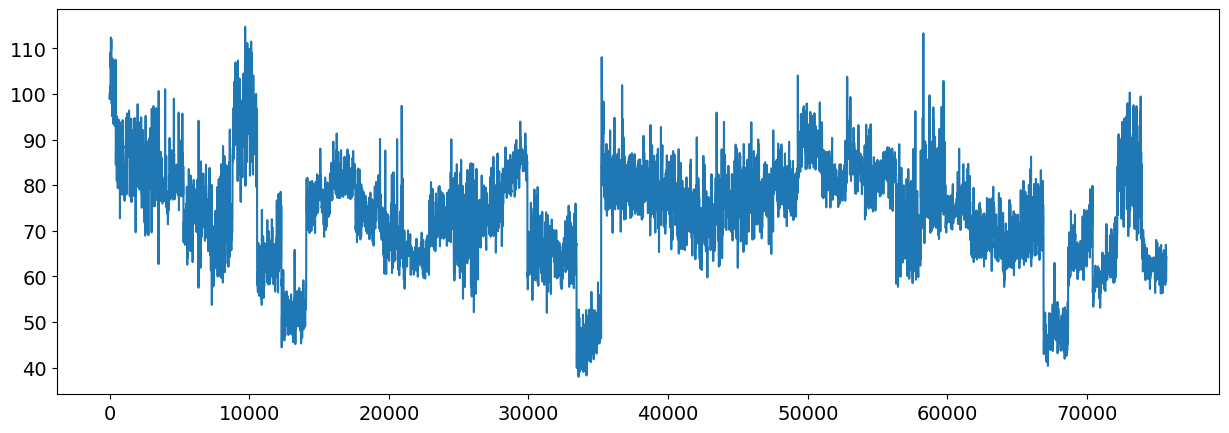

In [8]:
df.hrbl.plot()

<AxesSubplot: >

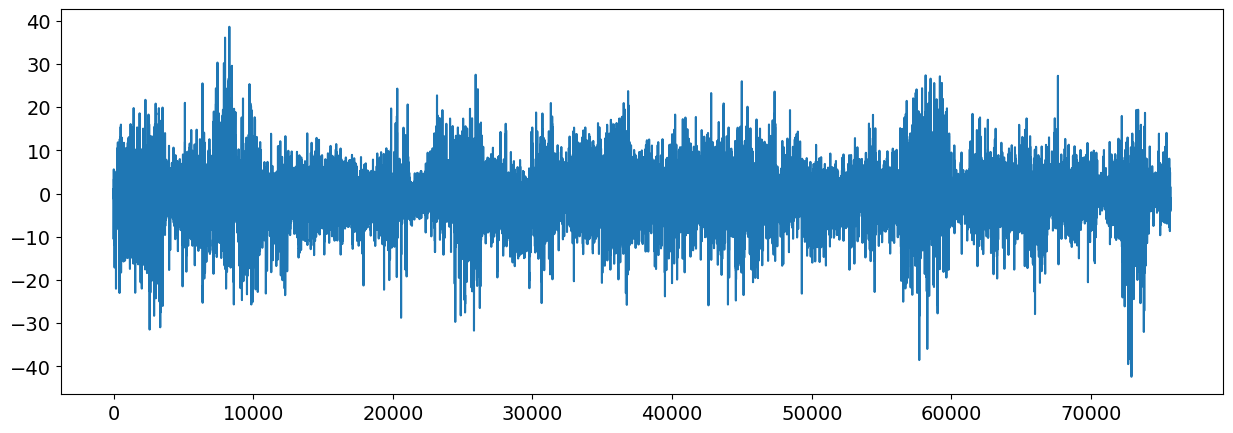

In [9]:
df.HRchange.plot()

In [6]:
for tr in range(1,160):
    for pat in valid_patients_hr:
        if(len(df[(df.trial==tr) & (df.subject==pat)].hrbl.unique())>1):
            print (df[(df.trial==tr) & (df.subject==pat)].hrbl)

In [7]:
result = pyreadr.read_r('../osfstorage-archive/RDS/heart.wide.rds')
df = result[None]
df

,subject,HR_PreAcq_CS-,HR_PreAcq_CS+,HR_Acq_CS-,HR_Acq_CS+,HR_Gen_all_CS-,HR_Gen_all_GS1,HR_Gen_all_GS2,HR_Gen_all_GS3,HR_Gen_all_GS4,HR_Gen_all_CS+,HR_Gen_all_lds,HR_Gen_all_diff,HR_Gen_all_level,HR_Gen_eyes_lds,HR_Gen_eyes_diff,HR_Gen_eyes_level,HR_Gen_mn_lds,HR_Gen_mn_diff,HR_Gen_mn_level
0,1,-4.355103,-3.402086,1.304726,1.522062,0.548240,-2.302359,0.670426,-0.040410,1.917760,0.913896,0.669714,0.365656,0.284592,1.402056,0.944670,-0.270620,-0.062629,-0.213359,0.839805
1,2,-3.452441,0.166759,-0.706629,-1.140099,-0.295604,-1.265690,-0.218763,2.033250,-5.005028,-0.432495,0.750008,-0.136891,-0.864055,0.086439,-2.960345,-0.450405,1.413577,2.686563,-1.277705
2,3,0.934985,-0.806902,0.061561,0.625418,0.191419,-1.018601,-0.380569,-0.332560,-0.005700,-1.007131,0.026502,-1.198550,-0.425524,-0.543983,-2.465007,-0.587674,0.596987,0.067907,-0.263374
3,4,0.150401,0.127759,-1.624846,0.869174,-2.277459,-0.136754,-0.836794,-1.744185,-1.842944,-1.418881,-0.708001,0.858578,-1.376170,-0.484778,-0.120058,-1.174937,-0.931223,1.837213,-1.577402
4,5,-3.355501,-3.311652,2.908239,1.038574,4.535475,3.090576,1.907950,-1.417337,2.555222,-2.547137,-0.539934,-7.082612,1.354125,0.703110,-4.396336,1.344381,-1.782977,-9.768889,1.363869
5,6,1.444876,-2.361436,-3.733209,-0.980997,1.179057,0.349132,-1.471090,-0.893095,-4.041528,-1.422850,1.392249,-2.601907,-1.050062,2.832743,-5.395479,-1.152516,-0.048245,0.191665,-0.947609
6,7,-2.048634,-1.662008,-1.740703,-1.293158,-2.013166,-0.246892,-3.186152,-0.794749,-0.837260,-2.131119,-0.805879,-0.117953,-1.534890,0.260563,-1.946271,-0.807444,-1.872322,1.710365,-2.262335
7,8,-0.073179,-0.751750,-0.379881,0.265791,-0.196247,-0.702296,-0.673383,-1.559649,-0.425624,-1.017657,0.233286,-0.821410,-0.762476,0.422642,1.109855,-1.285791,0.043930,-2.752676,-0.239161
8,10,-1.661789,-1.800592,-0.178181,-1.985808,-1.663032,-0.692801,0.096303,-0.597480,-1.063310,-0.429006,-0.481697,1.234026,-0.724888,-0.624526,0.922052,-0.202278,-0.338868,1.546000,-1.247497
9,13,-0.170158,2.822207,0.337890,-0.563633,0.146087,-1.111670,0.123301,-1.443408,-1.182590,-1.035896,0.458687,-1.181983,-0.750696,0.133117,-1.119617,-0.867240,0.784257,-1.244350,-0.634151


## sync exp

In [9]:
df_hr = all_subject_hr()

100%|██████████| 44/44 [01:40<00:00,  2.28s/it]


dataframe with hr data from <subject_num>.txt files with sampling rate 500hz

In [10]:
sub_1_hr_trigger = df_hr[df_hr.subject == '01']
sub_1_hr_trigger

,subject,hr,trigger
0,01,-0.073395,0
1,01,-0.073395,0
2,01,-0.072327,0
3,01,-0.071564,0
4,01,-0.070496,0
...,...,...,...
1421031,01,-0.001678,0
1421032,01,-0.000763,0
1421033,01,-0.000153,0
1421034,01,0.000458,0


In [8]:
def extract_hr_by_subject(subject_number: int) -> pd.DataFrame:
    """
    Extract heart data of the subject (reading tmp_hr csv files in tmp_hr folder) and return same data in one list
    :param subject_number:
    :return:
    """
    if subject_number not in valid_patients_hr:
        print('subject number not valid, probably this patient has not valid hr signals')
        return []
    if subject_number < 10:
        subject_number = '0' + str(subject_number)
    path_csv = str("tmp_eda/tmp_eda" + str(subject_number) + ".csv")
    pat_ = pd.read_csv(path_csv)
    df = {'subject': subject_number, 'hr': pat_['CH2'], 'trigger':pat_['CH28']}
    return pd.DataFrame(df)

def all_subject_hr() -> pd.DataFrame:
    """
    Create a single dataframe containing all the hr values of all subjects
    :return:
    """
    generic_df = pd.DataFrame(columns=['subject', 'hr','trigger'])
    for i in tqdm(valid_patients_hr):
        df_ = modified_hr_by_subject(i)
        #df_['time'] = np.arange(0, len(signals) / 100, 0.01)[:len(df_)] #no sense sta cosa ma senza non va
        generic_df = pd.concat([generic_df, df_], axis=0)
    return generic_df

def modified_hr_by_subject(subject: int) -> pd.DataFrame:
    """
    Read the hr from the given subjects and applies some changes: NO ACTION now
    :param subject:
    :return: new Dataframe with the corrected EDA values
    """
    df = extract_hr_by_subject(subject)
    return df

In [11]:
sub_1_hr_trigger[sub_1_hr_trigger.trigger==5]

,subject,hr,trigger
92457,01,-0.109253,5
92458,01,-0.105743,5
92459,01,-0.101776,5
92460,01,-0.098267,5
92461,01,-0.094147,5
...,...,...,...
1131676,01,0.030823,5
1131677,01,0.034943,5
1131678,01,0.038452,5
1131679,01,0.041351,5


In [36]:
sub2_trigger = df_hr[df_hr.subject=='02']
sub2_trigger

,subject,hr,trigger
0,02,-0.131683,0
1,02,-0.127258,0
2,02,-0.123749,0
3,02,-0.120087,0
4,02,-0.116577,0
...,...,...,...
960426,02,0.038452,0
960427,02,0.042267,0
960428,02,0.046539,0
960429,02,0.049744,0


In [37]:
sub2_trigger_lat = add_latency(sub2_trigger,-5,500)
sub2_trigger_lat

/var/folders/hn/nq1_cby521sbf58lnj9qj9mw0000gn/T/ipykernel_8929/3720546506.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['time'] = time_


,subject,hr,trigger,time
0,02,-0.131683,0,-5.000
1,02,-0.127258,0,-4.998
2,02,-0.123749,0,-4.996
3,02,-0.120087,0,-4.994
4,02,-0.116577,0,-4.992
...,...,...,...,...
960426,02,0.038452,0,1915.852
960427,02,0.042267,0,1915.854
960428,02,0.046539,0,1915.856
960429,02,0.049744,0,1915.858


In [15]:
def start_trial_time(df):
    start_trials = []
    prec = -1
    for i in tqdm(df.iterrows()):
        if i[1][2] == 5 and prec == 0:
            start_trials.append(i[1][3])
        prec = i[1][2]
    return start_trials

trials = start_trial_time(sub2_trigger_lat)
trials[:10]

960431it [01:20, 11866.47it/s]


[212.12800000028446,
 220.41800000032404,
 228.82400000036418,
 237.79600000040702,
 246.64200000044926,
 254.99400000048914,
 263.6800000005306,
 272.13600000057096,
 280.8360000006125,
 290.27200000065756]

In [16]:
len(trials)

160

In [17]:
trial_division = df_pat_1[df_pat_1['phasic_peak']==1]['time']

NameError: name 'df_pat_1' is not defined

In [ ]:
len([x for x in trials if x<750])

In [ ]:
plt.plot(list(sub2_trigger_lat.time), list(sub2_trigger_lat.hr),color='orange',label='hr')
plt.ylabel('hr var')
plt.ylim([-0.8, 1.8])
#plt.xlim(250,290)
plt.vlines(trials, ymin=-3,ymax=3, color='green', linewidth=3,label='trial separators')
plt.legend()
plt.xlabel('seconds')
plt.legend(bbox_to_anchor=(1,0), loc="lower left")
plt.show()

# Sync pupillary responses and eda phasic signal

In [12]:
print("extract eda for each patient")
df_sync_eda = all_subject_eda()

print("extract pupil for each patient")
df_sync_pupil = all_subject_pupil()
print(len(df_sync_pupil), len(df_sync_eda))

  0%|          | 0/43 [00:00<?, ?it/s]

extract eda for each patient


  0%|          | 0/43 [00:00<?, ?it/s]

extract pupil for each patient


100%|██████████| 43/43 [02:51<00:00,  3.99s/it]

6630880 6344655


In [13]:
df_sync_pupil.time.head()

0   -1.00
1   -0.99
2   -0.98
3   -0.97
4   -0.96
Name: time, dtype: float64

In [14]:
print("merge pupil and eda")

# cast to int in order to merge the two dataframes
df_sync_pupil.time = np.round(df_sync_pupil.time*100).astype(int)
df_sync_eda.time = np.round(df_sync_eda.time*100).astype(int)
df_merge = df_sync_pupil.merge(df_sync_eda, how='right', on = ['subject', 'time'])
df_merge.time = df_merge.time/100
df_merge

merge pupil and eda


,pupil_diameter,pupil_peak,subject,time,phasic,phasic_peak
0,NaN,NaN,1.0,-5.00,-0.017535,0
1,NaN,NaN,1.0,-4.99,-0.018487,0
2,NaN,NaN,1.0,-4.98,-0.019440,0
3,NaN,NaN,1.0,-4.97,-0.020392,0
4,NaN,NaN,1.0,-4.96,-0.021337,0
...,...,...,...,...,...,...
6344650,NaN,0,55.0,1739.55,-0.012728,0
6344651,NaN,0,55.0,1739.56,-0.012025,0
6344652,NaN,0,55.0,1739.57,-0.011332,0
6344653,NaN,0,55.0,1739.58,-0.010655,0


In [15]:
print("correct pupil diameter")
df_merge['pupil_diameter_corrected'] = correct_pupil_diam(list(df_merge.pupil_diameter))

correct pupil diameter


In [62]:
import csv
import matplotlib
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy import stats

# setup plots
#matplotlib.use("TkAgg")
plt.rcParams['figure.figsize'] = [15, 5]  # Bigger images
plt.rcParams['font.size'] = 16

# remove patients non valid for eda
notvalid = [x for x in range(34, 41)]
notvalid.append(9)
valid_patients_eda = [ele for ele in range(1, 56) if ele not in notvalid]

# remove patients non-valid for pupil
notvalid = [x for x in range(34, 41)]
notvalid.extend([9, 11, 20, 25, 42])
valid_patients_pupil = [ele for ele in range(1, 56) if ele not in notvalid]

NUM_TRIALS = 160

# select patients with either pupil and eda data
valid_pupil_eda = list(set(valid_patients_eda).intersection(set(valid_patients_pupil)))


def read_csv_pupil_raw(subject_number:int) -> pd.DataFrame:
    """
    Read pupil csv files
    :param subject_number:
    :return: A dataframe with pupil data of the subject subject_number
    """
    if subject_number not in valid_patients_pupil:
        print('subject number not valid, probably this patient has not valid pupil signals')
        return pd.DataFrame()
    if subject_number < 10:
        subject_number = '0' + str(subject_number)
    pupil1 = pd.read_csv('../osfstorage-archive/eye/pupil/Look0' + str(subject_number) + '_pupil.csv', sep=';')
    for i in pupil1.columns:
        if i != 'trial':
            for j in pupil1.index:
                pupil1.loc[j, i] = pupil1.loc[j, i].replace(',', '.')
    cols = pupil1.columns.drop('trial')

    pupil1[cols] = pupil1[cols].apply(pd.to_numeric, errors='coerce')
    return pupil1


def create_csv_pupil():
    """
    Create in current folder one tmp csv well formatted with pupil data for each subject
    :return: nothing
    """
    for subject in valid_patients_pupil:
        pupil_i = read_csv_pupil_raw(subject)
        name = 'tmp_pupil/tmp_pupil' + str(subject) + '.csv'
        pupil_i.to_csv(name, index=False)

def read_csv_pupil(subject:int) -> pd.DataFrame:
    """
    Read in current folder one tmp csv well formatted with pupil data
    :param subject:
    :return: Dataframe with pupil data of the subject
    """
    name = 'tmp_pupil/tmp_pupil'+str(subject)+'.csv'
    return pd.read_csv(name, sep=',')

def extract_pupil_by_subject(subject_number:int) -> list:
    """
    Extract pupil data of the subject and return same data in one list adding NaN values to reach same trial length of eda data
    :param subject_number:
    :return:
    """
    pupil = read_csv_pupil(subject_number)
    pupil_ = pupil.copy().drop(['trial'], axis=1)
    # convert all datas into one list
    pat1_pupil = []
    len_eda = int(len_trial_eda(subject_number))
    for i in range(160):
        raw_list = pupil_.loc[i, :].values.flatten().tolist()
        pat1_pupil = pat1_pupil + raw_list
    # pat1_pupil

    return pat1_pupil


def len_trial_eda(subject:int) -> int:
    """
    Calculate the length of the trial of the eda signal given subject number
    :param subject:
    :return: int that indicates the length
    """
    df_subject = modified_eda_by_subject(subject)
    return len(df_subject)/NUM_TRIALS

def extract_eda_by_subject(subject_number: int) -> list:
    """
    Extract eda data of the subject (reading tmp_eda csv files in current folder) and return same data in one list
    :param subject_number:
    :return:
    """
    if subject_number not in valid_patients_eda:
        print('subject number not valid, probably this patient has not valid eda signals')
        return []
    if subject_number < 10:
        subject_number = '0' + str(subject_number)
    path_csv = str("tmp_eda/tmp_eda" + str(subject_number) + ".csv")
    pat_eda = pd.read_csv(path_csv)['CH1']
    return pat_eda.to_numpy()


def extract_maxpupil_trial(subject: int) -> list:
    """
    Calculate the max value of pupil signal in each trial.
    :param subject:
    :return: a list with same length of the pupil signal filled with 0 or 1. 1 if the equivalent value is a max, 0 otherwise
    """
    pupil_csv = read_csv_pupil(subject)
    max_list = []
    max_length = max(700, int(len_trial_eda(subject)))
    for i in range(160):
        max_trial_list = list(pupil_csv.loc[i])[1:]
        max_ = max(max_trial_list)
        max_index = max_trial_list.index(max_)
        for j in range(max_length):
            if j == max_index:
                max_list.append(1)
            else:
                max_list.append(0)
    return max_list


def all_subject_pupil() -> pd.DataFrame:
    """
    Create a dataframe with all pupil data of all subject after adding latency
    :return: a dataframe with all pupil data of all subject with columns ['pupil_diameter', 'pupil_peak', 'subject']
    """
    generic_df = pd.DataFrame(columns=['pupil_diameter', 'subject'])
    for i in tqdm(valid_pupil_eda):
        df_ = modified_pupil_subject(i)
        generic_df = pd.concat([generic_df, df_], axis=0)

    return generic_df


def modified_pupil_subject(subject):
    # print(f'pupil: {subject}')
    person_i_all_pupil = extract_pupil_by_subject(subject)
    max_list_i = extract_maxpupil_trial(subject)
    # print(f'person: {len(person_i_all_pupil)}, max: {len(max_list_i)}')
    dict_ = {'pupil_diameter': person_i_all_pupil,
             'subject': subject}
    df_ = pd.DataFrame(dict_)
    df_ = add_latency(df_, -1)
    # df_['time'] = np.arange(0, len(df_) / 100, 0.01)
    return df_


def resample_eda(eda_signal:list) -> list:
    """
    Change sampling rate of the eda signal from 500hz to 100hz
    :param eda_signal: list of eda_signal with sampling rate of 500hz
    :return: list of eda_signal with sampling rate of 100hz
    """
    eda_new = []
    for x in range(len(eda_signal)):
        if x % 5 == 0:
            eda_new.append(eda_signal[x])
    return eda_new


def add_latency(dataframe:pd.DataFrame, secs:int, freq=100):
    """
    It creates the correct 'time' column of the given dataframe.
    :param dataframe:
    :param secs:
    :param freq: sampling of the signal in Hz by default is 100 hz
    """
    freq_sec = float(1/freq)
    new_df = dataframe
    time_ = []
    first_value = secs
    for i in range(len(dataframe)):
        time_.append(first_value)
        first_value += freq_sec
    #print(len(time_))
    new_df['time'] = time_
    return new_df


def all_subject_eda() -> pd.DataFrame:
    """
    Create a single dataframe containing all the EDA values of all subjects
    :return:
    """
    generic_df = pd.DataFrame(columns=['subject', 'phasic', 'phasic_peak'])
    for i in tqdm(valid_pupil_eda):
        df_ = modified_eda_by_subject(i)
        #df_['time'] = np.arange(0, len(signals) / 100, 0.01)[:len(df_)] #no sense sta cosa ma senza non va
        generic_df = pd.concat([generic_df, df_], axis=0)
    return generic_df


def modified_eda_by_subject(subject: int) -> pd.DataFrame:
    """
    Read the EDA from the given subjects and applies all the changes: removing last zeros from the list and the outliers at the end
    :param subject:
    :return: new Dataframe with the corrected EDA values
    """
    eda = extract_eda_by_subject(subject)
    # print(f'eda: {i}')
    #eda = resample_eda(eda)
    signals, info = nk.eda_process(eda, sampling_rate=500, method="neurokit")
    eda_phasic = signals['EDA_Phasic']
    #eda_phasic = remove_last_zeros(eda_phasic)
    #eda_phasic = remove_outliers(eda_phasic)
    df = {'subject': subject, 'phasic': eda_phasic, 'phasic_peak': signals['SCR_Peaks'][:len(eda_phasic)]}
    df_ = pd.DataFrame(df)
    df_ = add_latency(df_, -5, 500)
    return df_


def remove_outliers(l:list) -> list:
    """
    Remove outliers from a given list. An outlier is detected if its zscore exceeds a certain threshold.
    :param l: list
    :return: same list without outliers
    """
    z = np.abs(stats.zscore(l))
    THRESHOLD = 4
    PERC_LEN = 0.80
    # Position of the first outlier
    outliers = np.where(z>THRESHOLD)[0]
    for x in outliers:
        if x > PERC_LEN*len(l):
            l = l[:x]
            break
    '''
    for x in outliers:
        if x < (1-PERC_LEN)*len(l):
            l = l[x:]
            break
    '''
    return l

def remove_last_zeros(l:list)->list:
    """
    Remove last zeros from the list l, in our case the EDA file
    :param l: list
    :return: same list as l without trailing zeros
    """
    l=list(l)
    if len(l)>0:
        while abs(l[-1]) < 0.01:
            l.pop()
    return l
def correct_pupil_diam(l:list)->list:
    """
    Shift the pupil diameter values
    :param l: pupil diameter list
    :return: A list containing new pupil shifted
    """
    ADD_SHIFT = -2
    MULT_SHIFT = 4
    return [(x+ADD_SHIFT)*MULT_SHIFT if x != 'NaN' else float('NaN') for x in l]

In [16]:
df_merge.pupil_diameter = df_merge.pupil_diameter.astype(float)

## plot of eda and pupil signals of the first subject.

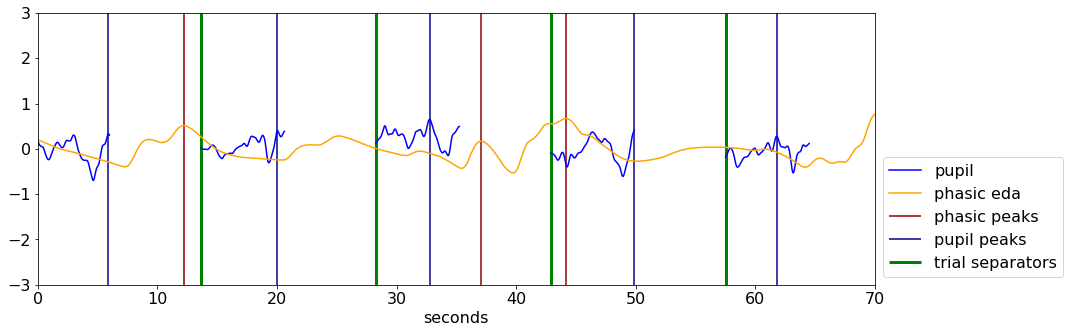

In [17]:
# plot subject 1
df_pat_1 = df_merge[df_merge.subject==1]
eda_peaks = df_pat_1[df_pat_1['phasic_peak']==1]['time']
pupil_peaks = df_pat_1[df_pat_1['pupil_peak']==1]['time']
#df_pat_1 = df_pat_1.replace('NaN', 0)
plt.plot(list(df_pat_1.time), list(df_pat_1.pupil_diameter_corrected),label='pupil',color='blue')
plt.plot(list(df_pat_1.time), list(df_pat_1.phasic),label='phasic eda',color='orange')
plt.vlines(eda_peaks, ymin=-3,ymax=3, color='darkred',label='phasic peaks')
plt.vlines(pupil_peaks, ymin=-3,ymax=3, color='darkblue',label='pupil peaks')
trial = np.arange(-1, 6000, len_trial_eda(1)/100)
plt.vlines(trial, ymin=-3,ymax=3, color='green', linewidth=3,label='trial separators')
plt.xlim(0, 10*7)
plt.xlabel("seconds")
plt.ylim(-3,3)
plt.legend(bbox_to_anchor=(1,0), loc="lower left")
plt.show()

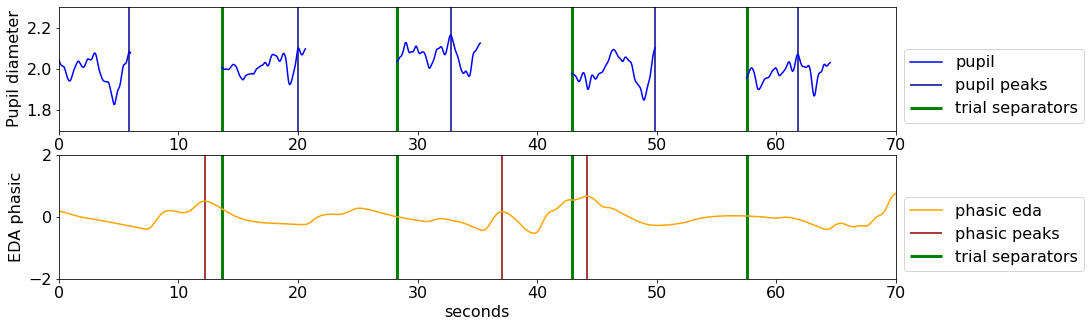

In [18]:
fig, ax = plt.subplots(2)
ax[0].set_xlim([0, 70])
ax[0].plot(list(df_pat_1.time), list(df_pat_1.pupil_diameter),color='blue',label='pupil')
ax[0].vlines(pupil_peaks, ymin=1.7, ymax=3,color='darkblue',label='pupil peaks')
ax[0].vlines(trial, ymin=-3,ymax=3, color='green', linewidth=3,label='trial separators')
ax[0].set(ylabel='Pupil diameter')
ax[0].set_ylim([1.7, 2.3])
ax[0].legend(bbox_to_anchor=(1,0), loc="lower left")
ax[1].plot(list(df_pat_1.time), list(df_pat_1.phasic),color='orange',label='phasic eda')
ax[1].set(ylabel='EDA phasic')
ax[1].set_xlim([0, 70])
ax[1].set_ylim([-2, 2])
ax[1].vlines(eda_peaks, ymin=-3, ymax=3,color='darkred',label='phasic peaks')
ax[1].vlines(trial, ymin=-3,ymax=3, color='green', linewidth=3,label='trial separators')
ax[1].legend()
plt.xlabel('seconds')
ax[1].legend(bbox_to_anchor=(1,0), loc="lower left")
plt.show()

## plot eda, ecg, pupil with patient 2

In [67]:
sub10_trigger = df_hr[df_hr.subject==10]
sub10_trigger_lat = add_latency(sub10_trigger,-5,500)
sub10_trigger_lat

/var/folders/hn/nq1_cby521sbf58lnj9qj9mw0000gn/T/ipykernel_8929/1000244686.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['time'] = time_


,subject,hr,trigger,time
0,10,0.046387,0,-5.000
1,10,0.052033,0,-4.998
2,10,0.057373,0,-4.996
3,10,0.062714,0,-4.994
4,10,0.068512,0,-4.992
...,...,...,...,...
858094,10,-0.147247,0,1711.188
858095,10,-0.150452,0,1711.190
858096,10,-0.153198,0,1711.192
858097,10,-0.155792,0,1711.194


In [68]:
pupil10 = modified_pupil_subject(10)

In [69]:
eda10 = modified_eda_by_subject(10)
eda10

,subject,phasic,phasic_peak,time
0,10,0.000242,0,-5.000
1,10,0.000208,0,-4.998
2,10,0.000174,0,-4.996
3,10,0.000140,0,-4.994
4,10,0.000107,0,-4.992
...,...,...,...,...
858094,10,0.000084,0,1711.188
858095,10,0.000078,0,1711.190
858096,10,0.000071,0,1711.192
858097,10,0.000065,0,1711.194


In [70]:
eda10.time = np.round(eda10.time*1000).astype(int)
sub10_trigger_lat.time = np.round(sub10_trigger_lat.time*1000).astype(int)
eda_hr = eda10.merge(sub10_trigger_lat[['hr', 'trigger', 'time']], how='inner', on = ['time'])
eda_hr.time = eda_hr.time/1000
eda10.time = eda10.time/1000
sub10_trigger_lat.time = sub10_trigger_lat.time/1000
eda_hr

/var/folders/hn/nq1_cby521sbf58lnj9qj9mw0000gn/T/ipykernel_8929/1235275050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub10_trigger_lat.time = np.round(sub10_trigger_lat.time*1000).astype(int)
/var/folders/hn/nq1_cby521sbf58lnj9qj9mw0000gn/T/ipykernel_8929/1235275050.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub10_trigger_lat.time = sub10_trigger_lat.time/1000


,subject,phasic,phasic_peak,time,hr,trigger
0,10,0.000242,0,-5.000,0.046387,0
1,10,0.000208,0,-4.998,0.052033,0
2,10,0.000174,0,-4.996,0.057373,0
3,10,0.000140,0,-4.994,0.062714,0
4,10,0.000107,0,-4.992,0.068512,0
...,...,...,...,...,...,...
858094,10,0.000084,0,1711.188,-0.147247,0
858095,10,0.000078,0,1711.190,-0.150452,0
858096,10,0.000071,0,1711.192,-0.153198,0
858097,10,0.000065,0,1711.194,-0.155792,0


In [72]:
trials = start_trial_time(sub10_trigger_lat)
len(trials)

858099it [00:55, 15472.57it/s]


160

In [73]:
trials

[70.2,
 78.388,
 88.034,
 98.03,
 106.89,
 116.138,
 126.218,
 135.172,
 144.474,
 154.368,
 164.188,
 174.058,
 183.886,
 192.176,
 200.948,
 209.626,
 218.064,
 226.886,
 235.834,
 244.766,
 253.452,
 263.438,
 272.662,
 282.224,
 291.388,
 301.178,
 309.934,
 318.644,
 327.984,
 336.874,
 345.916,
 354.074,
 362.522,
 372.42,
 381.93,
 391.918,
 401.398,
 410.958,
 419.37,
 429.008,
 438.956,
 447.96,
 457.588,
 466.878,
 475.384,
 484.954,
 493.946,
 502.188,
 684.592,
 692.824,
 702.6,
 710.75,
 718.964,
 727.622,
 736.218,
 746.27,
 755.416,
 764.164,
 774.09,
 783.242,
 792.92,
 801.392,
 811.172,
 820.668,
 829.41,
 838.16,
 846.458,
 854.63,
 863.356,
 871.9,
 880.484,
 889.25,
 898.188,
 907.82,
 916.308,
 926.096,
 934.266,
 942.59,
 950.88,
 960.704,
 968.978,
 979.04,
 988.766,
 998.698,
 1008.376,
 1016.774,
 1026.202,
 1035.438,
 1044.346,
 1052.742,
 1062.852,
 1071.294,
 1081.032,
 1089.904,
 1099.58,
 1109.262,
 1118.396,
 1128.302,
 1137.52,
 1147.56,
 1157.286,
 116

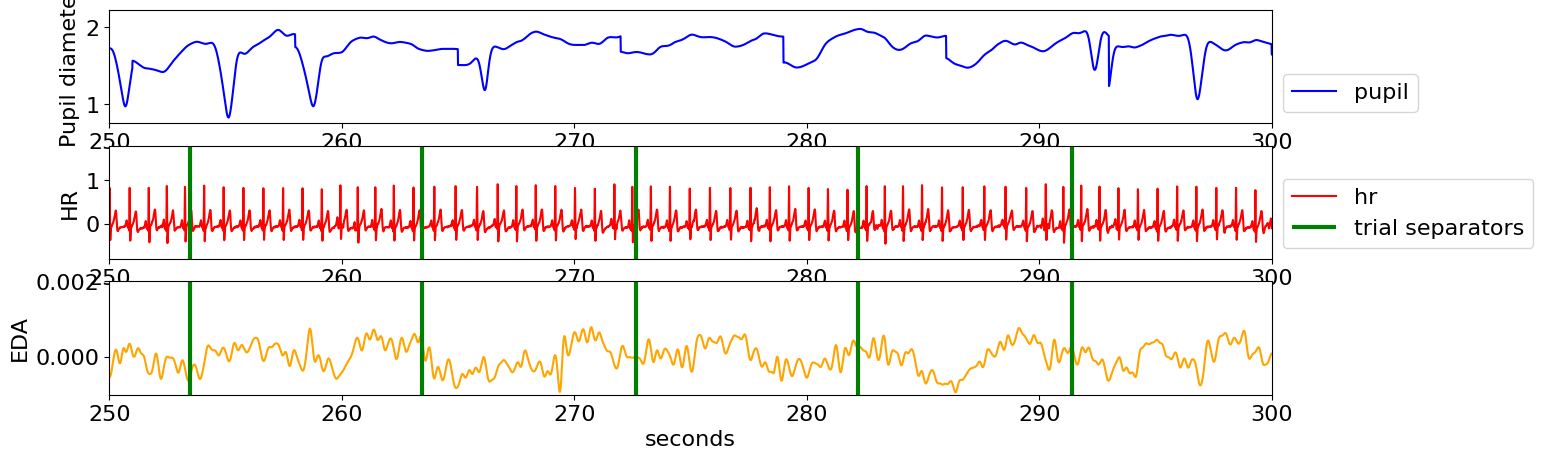

In [86]:
fig, ax = plt.subplots(3)
ax[0].plot(list(pupil10.time), list(pupil10.pupil_diameter),color='blue',label='pupil')
#ax[0].vlines(trial, ymin=-3,ymax=3, color='green', linewidth=3,label='trial separators')
ax[0].set(ylabel='Pupil diameter')
ax[0].set_xlim([250,300])
#ax[0].set_ylim([1.7, 2.3])
ax[0].legend(bbox_to_anchor=(1,0), loc="lower left")
ax[1].plot(list(eda_hr.time), list(eda_hr.hr),color='red',label='hr')
ax[1].set(ylabel='HR')
ax[1].vlines(trials, ymin=-3,ymax=3, color='green', linewidth=3,label='trial separators')
ax[1].legend()
ax[1].set_ylim([-0.8, 1.8])
ax[1].set_xlim([250, 300])
plt.xlabel('seconds')
ax[1].legend(bbox_to_anchor=(1,0), loc="lower left")
ax[2].plot(list(eda_hr.time), list(eda_hr.phasic),color='orange',label='phasic eda')
ax[2].set(ylabel='EDA')
ax[2].vlines(trials, ymin=-3,ymax=3, color='green', linewidth=3,label='trial separators')
ax[2].set_ylim([-0.001, 0.002])
ax[2].set_xlim([250, 300])

plt.show()

In [82]:
eda_hr.phasic[(eda_hr.time <= 300) & (eda_hr.time >= 200)]

102500    0.000678
102501    0.000677
102502    0.000676
102503    0.000675
102504    0.000673
            ...   
152496    0.000091
152497    0.000092
152498    0.000092
152499    0.000093
152500    0.000093
Name: phasic, Length: 50001, dtype: float64